### Seconde partie du notebook 

### Installation des bibliothèques nécessaires

Installation de la bibliothèque Loguru à partir d'un fichier local et de la bibliothèque bbox.


In [1]:
!pip install -q /kaggle/input/loguru-lib-ds/loguru-0.5.3-py3-none-any.whl
!pip install -q /kaggle/input/bbox-lib-ds

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


### Importation des bibliothèques

Importation des bibliothèques nécessaires pour l'analyse des données et le traitement des images, incluant numpy, tqdm, pandas, os, cv2, matplotlib, glob, shutil, sys, torch, PIL, et des utilitaires spécifiques au défi.


In [2]:
import numpy as np
from tqdm.notebook import tqdm

tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys

sys.path.append("../input/tensorflow-great-barrier-reef")
import torch
from PIL import Image
import greatbarrierreef
from bbox.utils import *


### Préparation des données d'entraînement

Lecture du fichier CSV contenant les données d'entraînement. Ajout d'une colonne `image_path` pour le chemin des images et conversion des annotations de chaîne de caractères en listes de dictionnaires. Affichage des premières lignes du dataframe.


In [3]:
# Train Data
df = pd.read_csv(f"/kaggle/input/tensorflow-great-barrier-reef/train.csv")
df["image_path"] = (
    f"/kaggle/input/tensorflow-great-barrier-reef/train_images/video_"
    + df.video_id.astype(str)
    + "/"
    + df.video_frame.astype(str)
    + ".jpg"
)
df["annotations"] = df["annotations"].progress_apply(eval)
display(df.head(2))


  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path
0,0,40258,0,0,0-0,[],/kaggle/input/tensorflow-great-barrier-reef/tr...
1,0,40258,1,1,0-1,[],/kaggle/input/tensorflow-great-barrier-reef/tr...


### Analyse des annotations

Ajout d'une colonne `num_bbox` représentant le nombre de boîtes de délimitation pour chaque image. Calcul et affichage du pourcentage d'images avec et sans boîtes de délimitation.


In [4]:
df["num_bbox"] = df["annotations"].progress_apply(lambda x: len(x))
data = (df.num_bbox > 0).value_counts() / len(df) * 100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")


  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


### Définition des fonctions utilitaires

Définition de la fonction `get_bbox` pour extraire les boîtes de délimitation à partir des annotations et de la fonction `get_imgsize` pour obtenir la taille des images. Initialisation des couleurs aléatoires pour la visualisation des boîtes de délimitation.


In [5]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes


def get_imgsize(row):
    row["width"], row["height"] = imagesize.get(row["image_path"])
    return row


np.random.seed(32)
colors = [
    (np.random.randint(255), np.random.randint(255), np.random.randint(255))
    for idx in range(1)
]

### Configuration des polices pour Ultralytics

Création du répertoire de configuration pour Ultralytics et copie de la police Arial.ttf dans ce répertoire.


In [6]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

### Chargement du modèle

Définition de la fonction `load_model` pour charger un modèle YOLOv5 personnalisé à partir d'un chemin de checkpoint local. Configuration des seuils de confiance et d'IoU pour le Non-Maximum Suppression (NMS) ainsi que d'autres paramètres de détection.


In [7]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load(
        "/kaggle/input/yolov5-lib-ds",
        "custom",
        path=ckpt_path,
        source="local",
        force_reload=True,
    )  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou = iou  # NMS IoU threshold
    model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

### Définition des fonctions de prédiction et de visualisation

- `predict`: Effectue des prédictions avec le modèle YOLOv5 sur une image donnée, retourne les boîtes de délimitation et les confiances correspondantes.
- `format_prediction`: Formate les boîtes de délimitation et les confiances en une chaîne de caractères pour les annotations.
- `show_img`: Affiche une image avec les boîtes de délimitation dessinées dessus, utilise les noms et les identifiants de classes pour les légendes.


In [8]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds = results.pandas().xyxy[0]
    bboxes = preds[["xmin", "ymin", "xmax", "ymax"]].values
    if len(bboxes):
        bboxes = voc2coco(bboxes, height, width).astype(int)
        confs = preds.confidence.values
        return bboxes, confs
    else:
        return [], []


def format_prediction(bboxes, confs):
    annot = ""
    if len(bboxes) > 0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf = confs[idx]
            annot += f"{conf} {xmin} {ymin} {w} {h}"
            annot += " "
        annot = annot.strip(" ")
    return annot


def show_img(img, bboxes, bbox_format="yolo"):
    names = ["starfish"] * len(bboxes)
    labels = [0] * len(bboxes)
    img = draw_bboxes(
        img=img,
        bboxes=bboxes,
        classes=names,
        class_ids=labels,
        class_name=True,
        colors=colors,
        bbox_format=bbox_format,
        line_thickness=2,
    )
    return Image.fromarray(img).resize((800, 400))

### Définition des paramètres du modèle

- `CKPT_PATH`: Chemin vers le fichier de checkpoint du modèle YOLOv5.
- `CONF`: Seuil de confiance pour le Non-Maximum Suppression (NMS).
- `IOU`: Seuil d'IoU pour le Non-Maximum Suppression (NMS).
- `IMG_SIZE`: Taille de l'image pour l'inférence.
- `AUGMENT`: Indicateur pour l'utilisation de l'augmentation de données pendant l'inférence.


In [9]:
CKPT_PATH = "../input/yolov5s6/f2_sub2.pt"
CONF = 0.30
IOU = 0.50
IMG_SIZE = 6400
AUGMENT = True

### Initialisation de l'environnement de compétition

- `env`: Création de l'environnement de compétition pour le défi de la Grande Barrière de Corail.
- `iter_test`: Initialisation de l'itérateur pour les données de test.


In [10]:
env = greatbarrierreef.make_env()
iter_test = env.iter_test()

### Prédiction et soumission des résultats

1. Chargement du modèle avec les paramètres définis.
2. Boucle sur les images de test :
    - Effectue des prédictions sur chaque image pour obtenir les boîtes de délimitation et les confiances.
    - Formate les prédictions en annotations.
    - Ajoute les annotations au dataframe de prédictions.
    - Soumet les prédictions à l'environnement de compétition.
    - Affiche les trois premières images avec les boîtes de délimitation dessinées.


YOLOv5 🚀 2024-5-30 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients
Adding AutoShape... 


0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


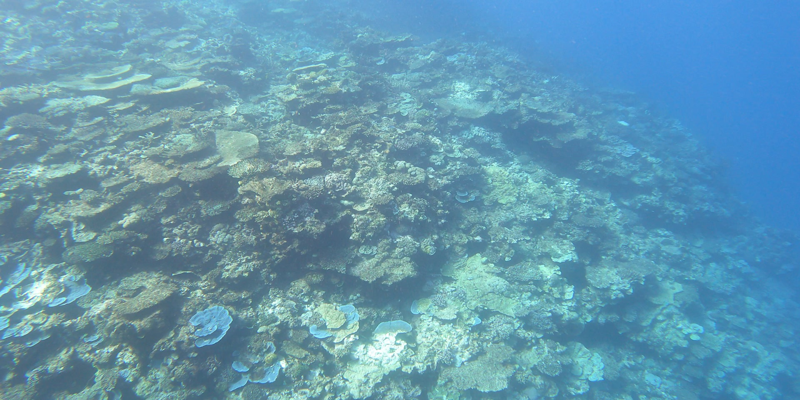

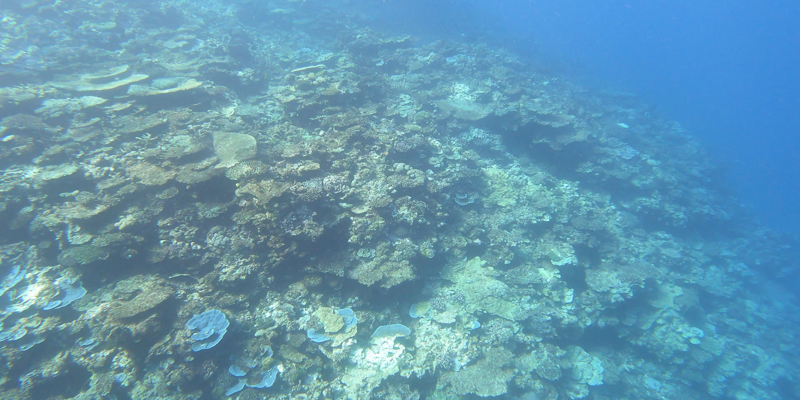

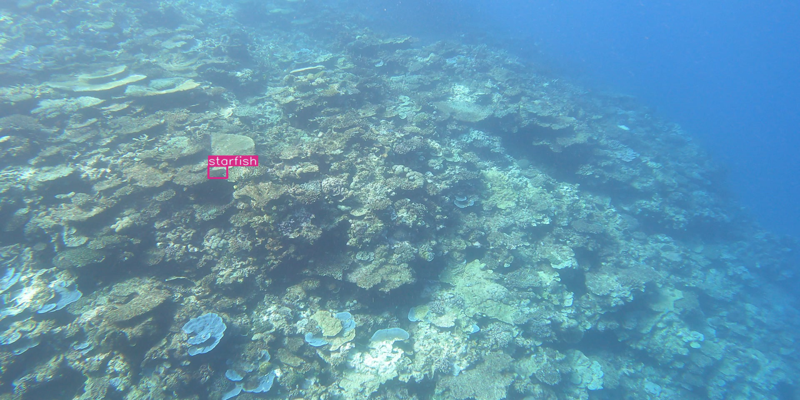

In [11]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes, confs = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    annot = format_prediction(bboxes, confs)
    pred_df["annotations"] = annot
    env.predict(pred_df)
    if idx < 3:
        display(show_img(img, bboxes, bbox_format="coco"))

In [12]:
sub_df = pd.read_csv("submission.csv")
sub_df.head()

,index,annotations
0,0,NaN
1,1,NaN
2,2,0.5037201046943665 333 298 30 22


En fin de compte, nos prédictions ont été soumises à l'environnement de compétition, et nous avons pu observer les annotations et les boîtes de délimitation sur certaines images de test. Par exemple, pour l'index 2, l'annotation était `0.5037201046943665 333 298 30 22`, indiquant une boîte de délimitation avec une confiance de 50.37% et les coordonnées (333, 298) avec une largeur de 30 et une hauteur de 22.